# Train model on CAN Data

### Explore automatic classification of steering angle

The goal of this notebook is to explore the automatic classification of steering angle in CAN signals.
A model is trained on snippets on can signals from steering and non steering can messages.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
file_list=[
    {
        "vehicle_name": "Chrysler Pacifica 2018",
        "dbc_name": "opendbc/chrysler_pacifica_2017_hybrid.dbc",
        "steer_brake_acc": [258, 284, 308],
        "file_name": "exported_csvs/6fb4948a7ebe670e_2019-11-12--00-35-53.bz2.csv"
    },
    {
        "vehicle_name": "Toyota Prius Prime 2020",
        "dbc_name": "opendbc/toyota_prius_2017_pt_generated.dbc",
        "steer_brake_acc": [37, 166, 581], # acc input looks strange
        "file_name": "exported_csvs/eb378db0873da597_2020-02-29--11-50-42--0--rlog.bz2.csv"
    },
    {
        "vehicle_name": "Acura ILX",
        "dbc_name": "opendbc/acura_ilx_2016_can_generated.dbc",
        "steer_brake_acc": [342, 420, 304], # acc input looks strange
        "file_name": "exported_csvs/rlog.bz2.csv"
    },    
]

In [4]:
file_path = "exported_csvs/rlog.bz2.csv"
sequences = list()
df = pd.read_csv(file_path, header=0)
values = df.values

In [5]:
len(values)

10882

In [6]:
targets = np.ones(len(values))*342

In [7]:
targets

array([342., 342., 342., ..., 342., 342., 342.])

In [8]:
from sklearn import preprocessing

x = df.values #returns a numpy array
columns = df.columns
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = columns

In [9]:
normalized_df=(df-df.min())/(df.max()-df.min())

In [10]:
df

,145,342,398,399,819,821,304,316,344,380,...,888,923,773,985,929,1034,1029,1064,1365,busTime
0,0.517419,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.517419,0.999405,0.810548,0.002197,1.0,1.000000,5.719254e-17,0.000001,9.136325e-07,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000090
2,0.517419,0.999405,0.810571,0.002197,1.0,1.000000,5.719254e-17,0.000001,9.136325e-07,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000188
3,0.517419,0.999405,0.810571,0.002274,1.0,1.000000,5.800570e-17,0.000001,1.106160e-06,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000283
4,0.517419,0.999405,0.810501,0.002152,1.0,1.000000,5.881886e-17,0.000001,1.106160e-06,9.313246e-07,...,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.000000,0.000374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10877,0.517135,0.999329,0.810432,0.993683,1.0,0.966322,3.936869e-03,0.000001,7.135548e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999628
10878,0.517135,0.999329,0.810432,0.993698,1.0,0.966322,3.952128e-03,0.000001,7.098872e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999716
10879,0.517135,0.999329,0.810455,0.993698,1.0,0.966322,3.952128e-03,0.000001,7.098872e-15,9.888004e-07,...,1.0,0.000487,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999811
10880,0.517135,0.999329,0.810455,0.993591,1.0,0.966322,3.952128e-03,0.000001,7.111097e-15,9.909291e-07,...,1.0,0.001432,0.003044,0.99093,1.0,0.854839,0.058854,0.99999,0.166667,0.999911


In [640]:
from random import randint

#This function creates the dataset for training the net
# It extracts snippets from the df dataframe above

def create_X_y_balanced(df, num_samples, sample_length):
    X = np.zeros([num_samples, sample_length])
    y = np.zeros(num_samples)
    for i in range(num_samples):
        # Half the time add a steering sample
        add_true_sample = randint(0,1)==1
        if add_true_sample:
            signal_index = 1 #steering value for acura ilx
        else:
            # Randomly choose which signal to write from
            signal_index = randint(0,df.shape[1]-1)
        chunk = []
        #print(signal_index)
        starting_point = randint(0,df.shape[0]-sample_length)
        
        for j in range(sample_length):
            # Since signal is very long, only a snippet is taken
            X[i][j] = df.iat[j+starting_point,signal_index]
            
        # Now create label based on what signal id we saved from    
        if df.columns[signal_index] in ["342"]: #steering value for acura ilx
            np.append(y,1)
            y[i]=1
        else:
            y[i]=0
    return [X,y]
    

X, y = create_X_y_balanced(df, 6000, 784)

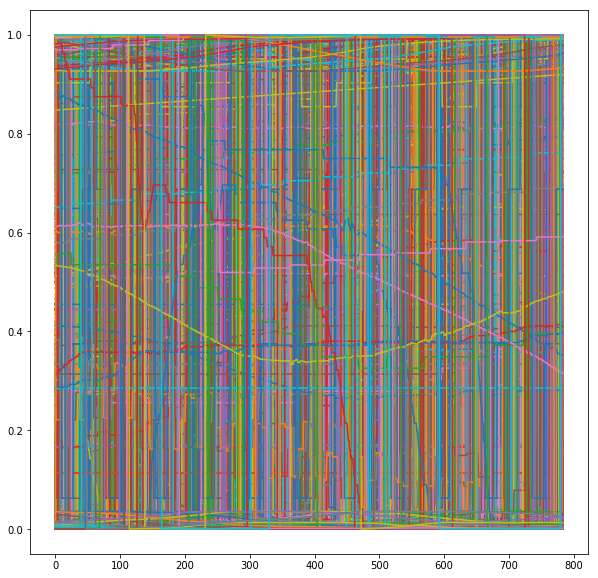

In [448]:
plt.figure(figsize=(10,10))
for i in range(0,X.shape[0]):
    plt.plot(X[i][:])
plt.show()

In [641]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [642]:
X_train = np.expand_dims(X_train, axis=2)

In [648]:
X_test = np.expand_dims(X_test, axis=2)

In [643]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Conv2D, Flatten
model = Sequential()
#model.add(Conv1D(10, 5, input_shape=(784,)))
model.add(Conv1D(32, 3, activation="relu", input_shape=(784,1)))
model.add(Flatten())
model.add(Dense(50, activation="relu"))
model.add(Dense(30, activation="relu"))
model.add(Dense(10, activation="relu"))

model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 782, 32)           128       
_________________________________________________________________
flatten_7 (Flatten)          (None, 25024)             0         
_________________________________________________________________
dense_88 (Dense)             (None, 50)                1251250   
_________________________________________________________________
dense_89 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_90 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 11        
Total params: 1,253,229
Trainable params: 1,253,229
Non-trainable params: 0
___________________________________________

In [644]:
model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics = ["accuracy"])

In [645]:
y_train.shape

(4800,)

In [646]:
model.fit(X_train, y_train, batch_size=100, epochs=500)

Train on 4800 samples
Epoch 1/500
4800/4800 [==============================] - 1s 152us/sample - loss: 0.6346 - accuracy: 0.6981
Epoch 2/500
4800/4800 [==============================] - 0s 99us/sample - loss: 0.5497 - accuracy: 0.7767
Epoch 3/500
4800/4800 [==============================] - 1s 118us/sample - loss: 0.4949 - accuracy: 0.7954
Epoch 4/500
4800/4800 [==============================] - 1s 116us/sample - loss: 0.4659 - accuracy: 0.8042
Epoch 5/500
4800/4800 [==============================] - 1s 118us/sample - loss: 0.4524 - accuracy: 0.8054
Epoch 6/500
4800/4800 [==============================] - 1s 119us/sample - loss: 0.4441 - accuracy: 0.8148
Epoch 7/500
4800/4800 [==============================] - 1s 115us/sample - loss: 0.4376 - accuracy: 0.8179
Epoch 8/500
4800/4800 [==============================] - 0s 101us/sample - loss: 0.4348 - accuracy: 0.8217
Epoch 9/500
4800/4800 [==============================] - 0s 101us/sample - loss: 0.4287 - accuracy: 0.8233
Epoch 10/500
480

4800/4800 [==============================] - 1s 110us/sample - loss: 0.3182 - accuracy: 0.8744
Epoch 77/500
4800/4800 [==============================] - 1s 105us/sample - loss: 0.3115 - accuracy: 0.8733
Epoch 78/500
4800/4800 [==============================] - 1s 105us/sample - loss: 0.3263 - accuracy: 0.8673
Epoch 79/500
4800/4800 [==============================] - 1s 104us/sample - loss: 0.3186 - accuracy: 0.8719
Epoch 80/500
4800/4800 [==============================] - 1s 106us/sample - loss: 0.3148 - accuracy: 0.8706
Epoch 81/500
4800/4800 [==============================] - 0s 102us/sample - loss: 0.3106 - accuracy: 0.8760
Epoch 82/500
4800/4800 [==============================] - 0s 104us/sample - loss: 0.3122 - accuracy: 0.8721
Epoch 83/500
4800/4800 [==============================] - 0s 103us/sample - loss: 0.3094 - accuracy: 0.8760
Epoch 84/500
4800/4800 [==============================] - 0s 102us/sample - loss: 0.3056 - accuracy: 0.8731
Epoch 85/500
4800/4800 [=================

4800/4800 [==============================] - 1s 105us/sample - loss: 0.2620 - accuracy: 0.8931
Epoch 152/500
4800/4800 [==============================] - 0s 104us/sample - loss: 0.2582 - accuracy: 0.8983
Epoch 153/500
4800/4800 [==============================] - 1s 105us/sample - loss: 0.2570 - accuracy: 0.8952
Epoch 154/500
4800/4800 [==============================] - 0s 103us/sample - loss: 0.2625 - accuracy: 0.8958
Epoch 155/500
4800/4800 [==============================] - 0s 103us/sample - loss: 0.2601 - accuracy: 0.8940
Epoch 156/500
4800/4800 [==============================] - 0s 104us/sample - loss: 0.3115 - accuracy: 0.8719
Epoch 157/500
4800/4800 [==============================] - 0s 101us/sample - loss: 0.2619 - accuracy: 0.8946
Epoch 158/500
4800/4800 [==============================] - 0s 104us/sample - loss: 0.2679 - accuracy: 0.8915
Epoch 159/500
4800/4800 [==============================] - 0s 101us/sample - loss: 0.2593 - accuracy: 0.8965
Epoch 160/500
4800/4800 [========

4800/4800 [==============================] - 1s 105us/sample - loss: 0.2434 - accuracy: 0.8965
Epoch 227/500
4800/4800 [==============================] - 0s 102us/sample - loss: 0.2447 - accuracy: 0.8992
Epoch 228/500
4800/4800 [==============================] - 0s 103us/sample - loss: 0.2361 - accuracy: 0.8998
Epoch 229/500
4800/4800 [==============================] - 0s 103us/sample - loss: 0.2416 - accuracy: 0.8929
Epoch 230/500
4800/4800 [==============================] - 1s 104us/sample - loss: 0.2440 - accuracy: 0.8973
Epoch 231/500
4800/4800 [==============================] - 1s 116us/sample - loss: 0.2378 - accuracy: 0.9021
Epoch 232/500
4800/4800 [==============================] - 1s 113us/sample - loss: 0.2402 - accuracy: 0.9004
Epoch 233/500
4800/4800 [==============================] - 1s 110us/sample - loss: 0.2330 - accuracy: 0.9035
Epoch 234/500
4800/4800 [==============================] - 1s 112us/sample - loss: 0.2520 - accuracy: 0.8900
Epoch 235/500
4800/4800 [========

4800/4800 [==============================] - 1s 106us/sample - loss: 0.2206 - accuracy: 0.9033
Epoch 302/500
4800/4800 [==============================] - 0s 104us/sample - loss: 0.2186 - accuracy: 0.9075
Epoch 303/500
4800/4800 [==============================] - 1s 106us/sample - loss: 0.2658 - accuracy: 0.8990
Epoch 304/500
4800/4800 [==============================] - 1s 105us/sample - loss: 0.2218 - accuracy: 0.9071
Epoch 305/500
4800/4800 [==============================] - 1s 104us/sample - loss: 0.2154 - accuracy: 0.9081
Epoch 306/500
4800/4800 [==============================] - 1s 108us/sample - loss: 0.2370 - accuracy: 0.9019
Epoch 307/500
4800/4800 [==============================] - 1s 108us/sample - loss: 0.2320 - accuracy: 0.9031
Epoch 308/500
4800/4800 [==============================] - 1s 107us/sample - loss: 0.2224 - accuracy: 0.9108
Epoch 309/500
4800/4800 [==============================] - 1s 106us/sample - loss: 0.2166 - accuracy: 0.9087
Epoch 310/500
4800/4800 [========

4800/4800 [==============================] - 1s 105us/sample - loss: 0.1957 - accuracy: 0.9210
Epoch 377/500
4800/4800 [==============================] - 0s 102us/sample - loss: 0.2081 - accuracy: 0.9152
Epoch 378/500
4800/4800 [==============================] - 0s 103us/sample - loss: 0.1851 - accuracy: 0.9212
Epoch 379/500
4800/4800 [==============================] - 0s 103us/sample - loss: 0.2119 - accuracy: 0.9158
Epoch 380/500
4800/4800 [==============================] - 0s 102us/sample - loss: 0.1830 - accuracy: 0.9240
Epoch 381/500
4800/4800 [==============================] - 0s 103us/sample - loss: 0.2517 - accuracy: 0.8956
Epoch 382/500
4800/4800 [==============================] - 0s 103us/sample - loss: 0.1874 - accuracy: 0.9210
Epoch 383/500
4800/4800 [==============================] - 0s 103us/sample - loss: 0.1946 - accuracy: 0.9171
Epoch 384/500
4800/4800 [==============================] - 0s 102us/sample - loss: 0.1831 - accuracy: 0.9229
Epoch 385/500
4800/4800 [========

4800/4800 [==============================] - 1s 104us/sample - loss: 0.1654 - accuracy: 0.9342
Epoch 452/500
4800/4800 [==============================] - 0s 104us/sample - loss: 0.1742 - accuracy: 0.9360
Epoch 453/500
4800/4800 [==============================] - 0s 104us/sample - loss: 0.1430 - accuracy: 0.9473
Epoch 454/500
4800/4800 [==============================] - 0s 104us/sample - loss: 0.1495 - accuracy: 0.9421
Epoch 455/500
4800/4800 [==============================] - 1s 104us/sample - loss: 0.1369 - accuracy: 0.9469
Epoch 456/500
4800/4800 [==============================] - 1s 107us/sample - loss: 0.1502 - accuracy: 0.9402
Epoch 457/500
4800/4800 [==============================] - 1s 106us/sample - loss: 0.1587 - accuracy: 0.9423
Epoch 458/500
4800/4800 [==============================] - 1s 106us/sample - loss: 0.1893 - accuracy: 0.9317
Epoch 459/500
4800/4800 [==============================] - 1s 107us/sample - loss: 0.1934 - accuracy: 0.9233
Epoch 460/500
4800/4800 [========

In [649]:
test_loss, test_acc = model.evaluate(X_test, y_test)

1200/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [215]:
from random import randint

#This function creates the dataset for training the net
# It extracts snippets from the df dataframe above

def extract_random_sample(df, sample_length):
    x = np.zeros(sample_length)
    # Randomly choose which signal to write from
    signal_index = randint(0,df.shape[1]-1)
    chunk = []
    #print(signal_index)
    starting_point = randint(0,df.shape[0]-sample_length)

    for j in range(sample_length):
        # Since signal is very long, only a snippet is taken
        x[j] = df.iat[j+starting_point,signal_index]

    return x
    

x = extract_random_sample(df, 784)

x=np.tile(x,(1,1))

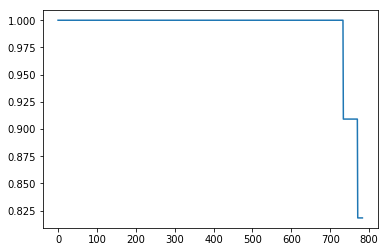

In [216]:
plt.plot(x[0][:])

In [217]:
x.shape

(1, 784)

In [218]:

result = model.predict(x)

In [219]:
len(result)

1

In [209]:
help(model)

Help on Sequential in module tensorflow.python.keras.engine.sequential object:

class Sequential(tensorflow.python.keras.engine.training.Model)
 |  Sequential(layers=None, name=None)
 |  
 |  Linear stack of layers.
 |  
 |  Arguments:
 |      layers: list of layers to add to the model.
 |  
 |  Example:
 |  
 |  ```python
 |  # Optionally, the first layer can receive an `input_shape` argument:
 |  model = Sequential()
 |  model.add(Dense(32, input_shape=(500,)))
 |  # Afterwards, we do automatic shape inference:
 |  model.add(Dense(32))
 |  
 |  # This is identical to the following:
 |  model = Sequential()
 |  model.add(Dense(32, input_dim=500))
 |  
 |  # And to the following:
 |  model = Sequential()
 |  model.add(Dense(32, batch_input_shape=(None, 500)))
 |  
 |  # Note that you can also omit the `input_shape` argument:
 |  # In that case the model gets built the first time you call `fit` (or other
 |  # training and evaluation methods).
 |  model = Sequential()
 |  model.add(Dens

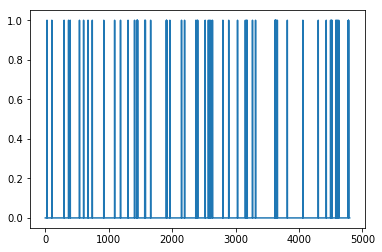

In [220]:
plt.plot(y_train)

In [222]:
np.mean(y_train)

0.0125

In [223]:
result = model.predict(X_train)

In [224]:
result

array([[0.00312996],
       [0.33886862],
       [0.00101224],
       ...,
       [0.00101224],
       [0.00622189],
       [0.00351337]], dtype=float32)

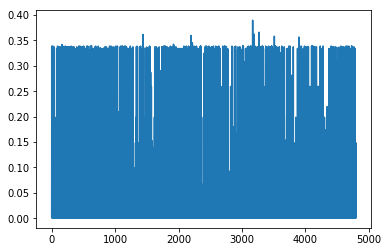

In [227]:
plt.plot(result)

In [661]:
index = 2

In [715]:
x = X_test[index][:]
x = np.tile(x,(1,1))

In [716]:
x.shape

(784, 1)

In [717]:
y_train[index]

1.0

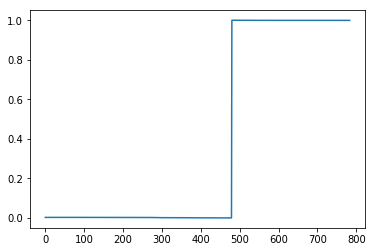

In [718]:
plt.plot(x)

In [719]:
x.shape

(784, 1)

In [720]:
x=np.expand_dims(x, axis=1)
#x = np.tile(x,(1,1))
model.predict(x)

ValueError: Error when checking input: expected conv1d_17_input to have shape (784, 1) but got array with shape (1, 1)

In [398]:
steering_samples_indexes = np.where(y_train==1)

In [650]:
np.where(y_test==1)

(array([   2,    3,    5,    6,    7,    8,   11,   12,   18,   19,   20,
          24,   25,   28,   30,   36,   42,   44,   49,   50,   52,   53,
          54,   55,   56,   59,   60,   61,   65,   67,   69,   73,   75,
          77,   79,   80,   81,   82,   83,   84,   85,   86,   87,   94,
          96,   97,   98,  101,  102,  103,  104,  106,  111,  112,  114,
         116,  117,  118,  123,  128,  129,  131,  134,  137,  138,  139,
         142,  143,  147,  148,  150,  153,  155,  159,  163,  164,  171,
         175,  176,  177,  178,  179,  183,  184,  185,  186,  187,  188,
         190,  192,  193,  197,  198,  200,  203,  205,  207,  208,  209,
         211,  212,  217,  219,  220,  221,  224,  225,  227,  228,  229,
         233,  234,  235,  236,  242,  243,  246,  248,  249,  250,  257,
         262,  264,  270,  271,  272,  273,  278,  280,  281,  286,  288,
         289,  291,  293,  294,  295,  296,  298,  299,  303,  304,  305,
         306,  307,  308,  309,  310, 

In [ ]:
x=X_train[index][:]
x=np.tile(x,(1,1))

In [428]:
predictions = model.predict(X_train)

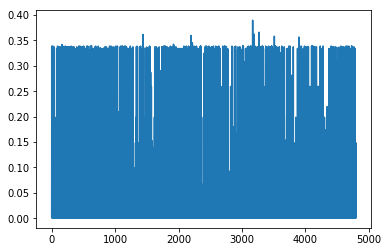

In [429]:
plt.plot(predictions)

In [430]:
# Issue: samples are almost always non steering so model just predicts not steering all the time

In [431]:
np.mean(predictions)

0.046590727

In [432]:
np.max(predictions)

0.38964254

# Results

It is possible to classify steering and non steering signals in a can bus with 80% accuracy using a neural net.

TODOs
* Train the model on the can bus of more than one vehicle. Even though can ids were not given to the network, it is possible that the network learned to discern steering vs non-steering based on features specific to this vehicle.
* Add a convnet. The current model uses just dense layers which are not ideal for detecting the shape of signals
* Add angle unwrapping to remove angle jumps
